In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Nout = 50
dt = 0.001
dtout = Nout*dt
t_array = np.arange(0,21*dtout,dt)      # Time vector
X0 = np.array([-0.587, -0.563, 16.870]) # True initial state of the system
P0 = np.eye(3)*1/15                     # Accuracy of assumed model

In [3]:
def tent_map(gprev, a):
    '''
    iterate the tent map for scalar or array input.
    '''
    gprev = np.asarray(gprev)
    scalar_input = False
    if gprev.ndim == 0:
        gprev = gprev[None]  # Makes x 1D
        scalar_input = True
        
    gnext = np.zeros_like(gprev)
    for ig, g in enumerate(gprev):
        if g >= -a/2 and g < 0:
            gnext[ig] = 1.99999 * g + a/2
        else:
            gnext[ig] = -1.99999 * g + a/2
            
    if scalar_input:
        return np.squeeze(gnext)
    return gnext


def iter_true_model(Xprev, gprev, dt, sigma=10, rho=28, beta=8/3):
    '''
    Iterate the reference trajectory one step for multiple 
    ensemble members simultaneously.
    '''
    update = np.ones_like(Xprev)
    update[0] = dt*sigma*(Xprev[1] - Xprev[0]) + dt*g[0]
    update[1] = dt*(Xprev[0]*(rho-Xprev[2])-Xprev[1]) + dt*g[1]
    update[2] = dt*(Xprev[0]*Xprev[1] - beta*Xprev[2]) + dt*g[2]
    Xnext = Xprev + update
    return Xnext

def observe(X, Nout):
    '''
    Make an observation from the reference trajectory
    '''
    xi = 4*(2**(-.5)-.5)
    Xobs = np.zeros_like(X[0,Nout::Nout])
    
    for ix, x in enumerate(X[0,Nout::Nout]):
        XI = np.zeros(200)
        for i in range(200):
            xi = tent_map(xi, a=4)
            XI[i] = xi
        XI = XI[::10]
        Xobs[ix] = x + (1/20) * np.sum(XI)
    return Xobs

def iter_forward_model(Xprev, sigma, dt=dt, rho=28, beta=8/3):
    '''
    Iterate the assumed forward model one step for multiple 
    ensemble members simultaneously.
    '''
    M = Xprev.shape[0]
    update = np.ones_like(Xprev)
    xi1 = np.random.normal(0,np.sqrt(0.0838),M)
    xi2 = np.random.normal(0,np.sqrt(0.0838),M)
    xi3 = np.random.normal(0,np.sqrt(0.0838),M)
    update[:,0] = dt*sigma*(Xprev[:,1] - Xprev[:,0]) + np.sqrt(dt)*xi1
    update[:,1] = dt*(Xprev[:,0]*(rho-Xprev[:,2])-Xprev[:,1]) + np.sqrt(dt)*xi2
    update[:,2] = dt*(Xprev[:,0]*Xprev[:,1] - beta*Xprev[:,2]) + np.sqrt(dt)*xi3
    Xnext = Xprev + update
    return Xnext

def SIRfilter(z0, yobs, R, lamb):
    '''
    Apply the SIR filter.
    Return the forecast trajectories.
    '''
    M = z0.shape[0]
    wi = np.ones(M)/M
    z = z0
    trajs = np.zeros((M,3,len(yobs)))
    
    for k, y in enumerate(yobs):
        for i in range(Nout):
            z = iter_forward_model(z, lamb) #forecast
        trajs[:,:,k] = z
        wi = (wi * likelihood(z[:,0],y,R)) / (wi * likelihood(z[:,0],y,R)).sum()
        z = residual_resampling(z, wi) #analysis
        wi = np.ones(M)/M
        
        
    return trajs
    
def likelihood(y, zf, R):
    '''
    evaluate gaussian likelihood function with variance R
    for observation y and model forecast zf
    '''
    likelihood = 1/(np.sqrt(R*2*np.pi)) * np.exp(-1/2 * ((y-zf)/(np.sqrt(R)))**2)
    return likelihood


def residual_resampling(z, wi):
    '''
    Perform residual resampling
    '''
    M = z.shape[0]
    
    Q = (M*wi).astype(int)
    L = M - Q.sum()
    
    xi_bar = np.zeros(M)
    
    cdf = np.cumsum(wi)
    for l in range(L):
        u = np.random.uniform(0,1)
        try:
            i = np.where(cdf >= u)[0][0]
        except:
            i = np.where(cdf >= u)[0]
                
        xi_bar[i] += 1
    xi = Q + xi_bar
    
    z_new = []
    for i_val, val in enumerate(xi):
        for i in range(int(val)):
            z_new.append(z[i_val])
    
    
    return np.array(z_new)

In [4]:
ref_traj = np.zeros((3,len(t_array)))  #initialise reference trajectory
ref_traj[:,0] = X0                     #insert initial conditins at t=0
a_ref = 1/np.sqrt(dt)
g0 = np.array([a_ref*(2**(-.5)-.5), a_ref*(3**(-.5)-.5), a_ref*(5**(-.5)-.5)])

g = g0
X = X0
for it, t in enumerate(t_array[:-1]):  #Build the reference trajectory iteratively
    X = iter_true_model(X, g, dt)
    g = tent_map(g, a=a_ref)
    ref_traj[:,it+1] = X                

In [5]:
yobs = np.zeros(len(t_array))                    #Initiate observation trajectory
yobs[:] = np.nan
yobs[Nout::Nout] = observe(ref_traj, Nout=Nout)  #Fill observation trajectory with observations of 
                                                 #the reference trajectory. Fits to time vector t_array

yobs_compact = yobs[~np.isnan(yobs)]             #Extract non-nan values. yobs_compact does not fit
                                                 #to t_array.

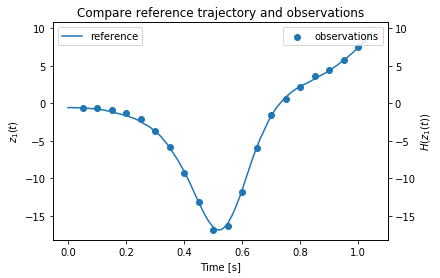

In [6]:
fig, ax = plt.subplots(1)
ax.plot(t_array, ref_traj[0,:], label='reference')
ax2=ax.twinx()
ax2.scatter(t_array, yobs, label='observations')
ax2.set_ylim(ax.get_ylim())
ax.legend()
ax2.legend()
ax.set_xlabel('Time [s]')
ax.set_ylabel(r'$z_1(t)$')
ax2.set_ylabel(r'$H(z_1(t))$')
ax.set_title('Compare reference trajectory and observations')
plt.show()

In [7]:
L = 10000 #Number of lambdas to evaluate
M = 20    #Ensemble size

In [10]:
E0 = 0
El = E0
lambdas = []
for l in range(L):
    if l%100 ==0:
        print(f'step {l}/{L}')
        
    z0 = np.array(np.random.multivariate_normal(X0,P0,M)) # Initialise M initial states
    lamb_prop = np.random.uniform(7,11)                   # Draw a proposition for lambda
    trajs = SIRfilter(z0, yobs_compact, 1/15, lamb_prop)[:,0,:] # Calculate forecast trajectories
    Enew = 1
    
    for k in range(len(yobs_compact)):
        Enew = Enew*(1/M * (likelihood(yobs_compact[k],trajs[:,k],1/15)).sum()) # Calculate evidence of ensemble
        
    p = np.min(np.array([1, Enew/El])) # Probability of acceptance
    
    dec = np.random.uniform(0,1,1)      # Draw random number to decide whether 
                                        # to accept the proposed lambda or not
    if dec <= p:
        lamb = lamb_prop
        El = Enew
        
    lambdas.append(lamb)


step 0/10000


/home/jakiw/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


step 100/10000
step 200/10000
step 300/10000
step 400/10000
step 500/10000
step 600/10000
step 700/10000
step 800/10000
step 900/10000
step 1000/10000
step 1100/10000
step 1200/10000
step 1300/10000
step 1400/10000
step 1500/10000
step 1600/10000
step 1700/10000
step 1800/10000
step 1900/10000
step 2000/10000
step 2100/10000
step 2200/10000
step 2300/10000
step 2400/10000
step 2500/10000
step 2600/10000
step 2700/10000
step 2800/10000
step 2900/10000
step 3000/10000
step 3100/10000
step 3200/10000
step 3300/10000
step 3400/10000
step 3500/10000
step 3600/10000
step 3700/10000
step 3800/10000
step 3900/10000
step 4000/10000
step 4100/10000
step 4200/10000
step 4300/10000
step 4400/10000
step 4500/10000
step 4600/10000
step 4700/10000
step 4800/10000
step 4900/10000
step 5000/10000
step 5100/10000
step 5200/10000
step 5300/10000
step 5400/10000
step 5500/10000
step 5600/10000
step 5700/10000
step 5800/10000
step 5900/10000
step 6000/10000
step 6100/10000
step 6200/10000
step 6300/10000
s

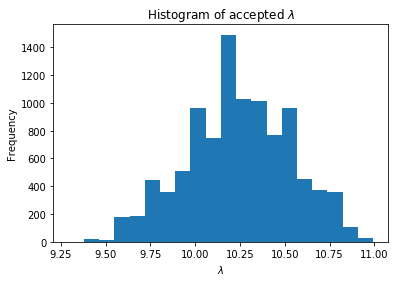

In [11]:
fig, ax = plt.subplots(1)
ax.hist(lambdas, bins=20)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of accepted $\lambda$')
plt.show()